In [4]:
from astropy.io import fits
import numpy as np
import astropy
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats 
from scipy.optimize import curve_fit


from matplotlib.backends.backend_pdf import PdfPages

In [106]:
file_path = '/home/arya/Desktop/Det_gain_offset_merged_data/Det_V/europium.fits'
hdulist = fits.open(file_path)

In [108]:
data = hdulist[1].data
print(Table(data))

   time    detid pixid pha 
---------- ----- ----- ----
3560729653     1     9  664
3560729746     1   132  751
3560729829     0   168 1431
3560729873     1    35 1035
3560729950     0   228 1333
3560729974     1    62 1631
3560729999     0   150 1935
3560730185     1   201 1288
3560730348     0   225 1633
3560730374     1   122 1542
       ...   ...   ...  ...
2974629195     1   138  743
2974629246     1   197 1557
2974629295     1    86 1616
2974629378     1    79 1783
2974629815     1   153 1799
2974629938     1   124 1511
2974630119     1   195 1306
2974630170     1   150 1238
2974630515     1   211 1041
2974630614     1    77 1480
Length = 7685120 rows


In [110]:
# Filter data for detid == 
detid = data[data['detid'] == int(input("Detector Id (0/1) = "))]

Detector Id (0/1) =  1


In [112]:
source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
det_id = int(input("detid (0/1) = "))
if det_id == 0:
    if source == "Am":
        pha_min = 800  # Minimum PHA value
        pha_max = 1200 # Maximum PHA value
        Energy_value = 59.6
    elif source == "Ba1":
        pha_min = 304 
        pha_max = 608
        Energy_value = 30.85
    elif source == "Ba2":
        pha_min = 1120 
        pha_max = 1632
        
        Energy_value = 81
    elif source == "Eu2":
        pha_min = 1552  
        pha_max = 1936
        Energy_value = 105.31
    else: 
        pha_min = 1232
        pha_max =1552
        Energy_value = 85.55
    print(pha_min,pha_max,Energy_value)

elif det_id == 1:
    if source == "Am":
        pha_min = 800  # Minimum PHA value
        pha_max = 1200 # Maximum PHA value
        Energy_value = 59.6
    elif source == "Ba1":
        pha_min = 304 
        pha_max = 608
        Energy_value = 30.85
    elif source == "Ba2":
        pha_min = 1120  
        pha_max = 1536+64+32
        
        Energy_value = 81
    elif source == "Eu2":
        pha_min = 1632+16  
        pha_max = 2048+16
        Energy_value = 105.31
    else: 
        pha_min = 1312-32
        pha_max =1632+16
        Energy_value = 85.55
    print(pha_min,pha_max,Energy_value)
else:
    print("Detector ID not supported.")


source name (Am/Ba1/Ba2/Eu1/Eu2) =  Eu2
detid (0/1) =  1


1648 2064 105.31


detid =   1


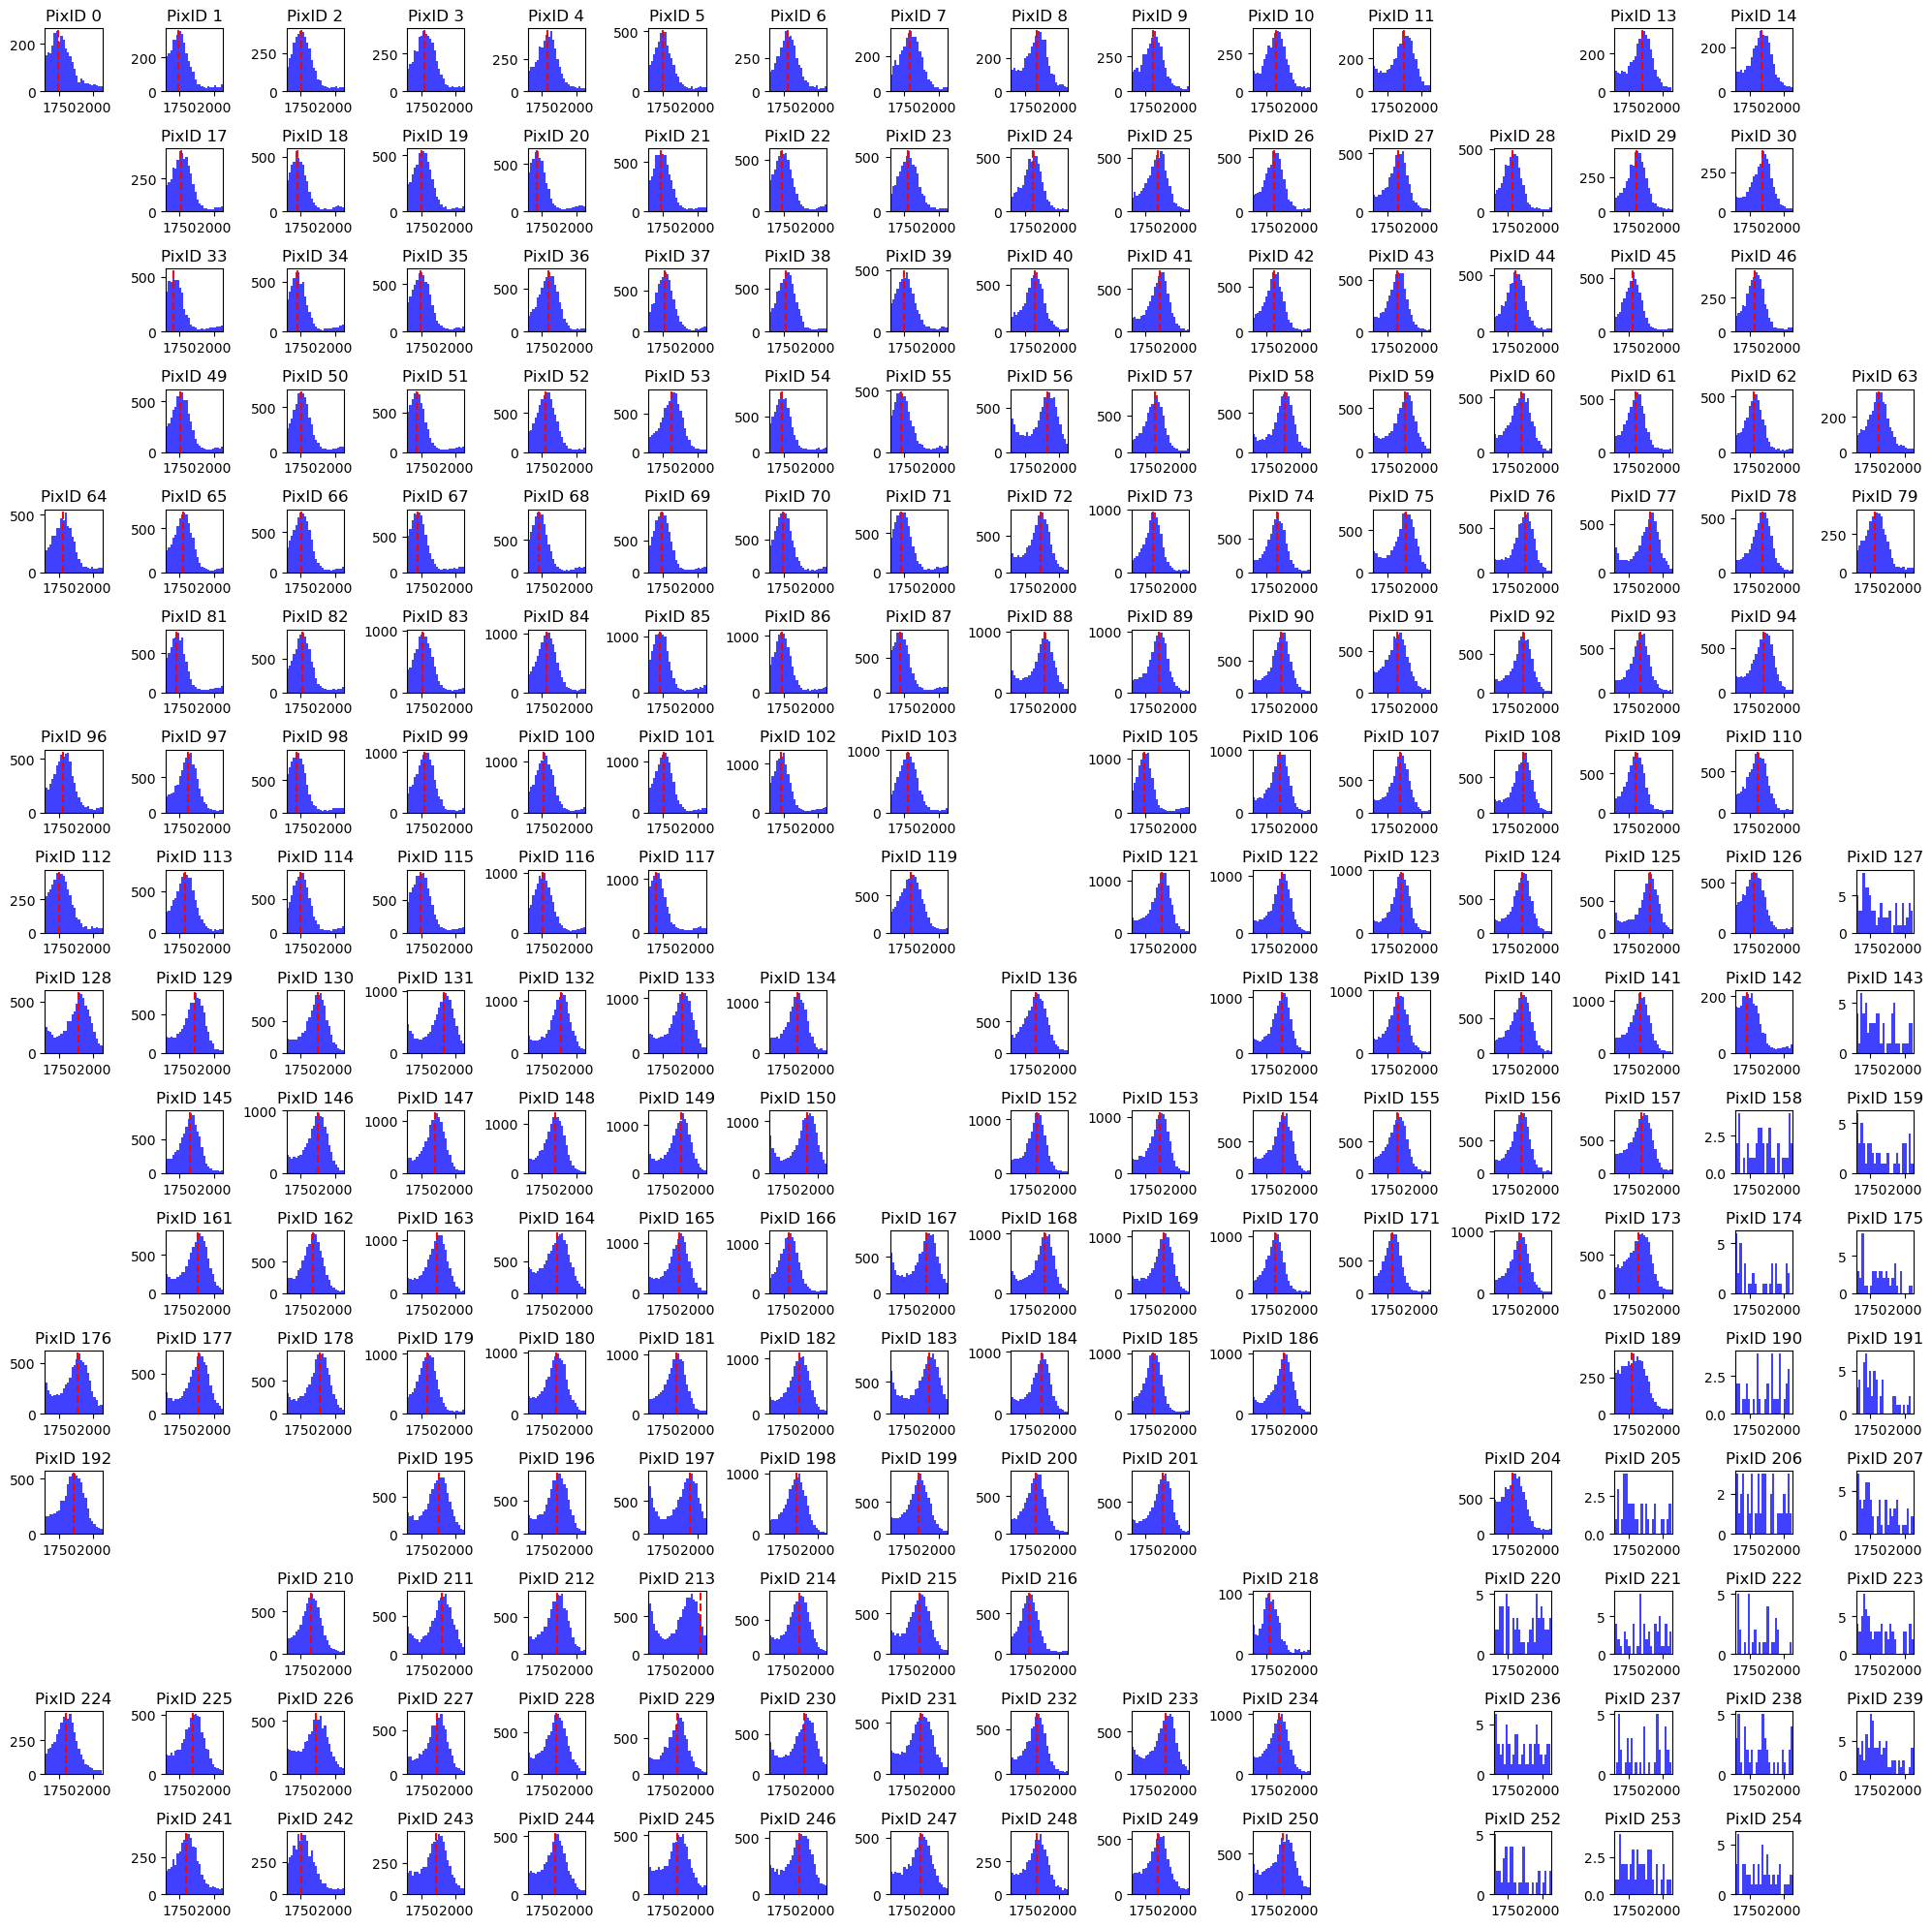

In [114]:
def gauss(x, amp, mean, stdev):
    return amp * np.exp(-(x - mean) ** 2 / (2 * stdev ** 2))

bin_count = int((pha_max - pha_min)/16)

max_count_pha_list = []
max_count_pha_list_OFF = []

for pixid in range(256):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 100:
        N, bins = np.histogram(filtered_data, bins=bin_count)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        p0 = [np.max(N), np.mean(filtered_data), np.std(filtered_data)]
        params = None
        pcov = None
        
        for i in range(10):
            try:
                params, pcov = curve_fit(gauss, bin_centers, N, p0, maxfev=200)
                if np.all((np.abs(p0 - params) / np.sqrt(np.diag(pcov))) > 1):
                    break
                p0 = params
            except RuntimeError:
                continue

        if params is not None:
            max_count_pha_list.append((pixid, params[1], np.sqrt(np.diag(pcov))[1], Energy_value))
        else:
            max_count_pha_list_OFF.append((pixid, None, Energy_value))
    else:
        max_count_pha_list_OFF.append((pixid, None, Energy_value))

# Create 16x16 histogram plot
fig, axes = plt.subplots(16, 16, figsize=(20, 20))
axes = axes.flatten()

for ax, pixid in zip(axes, range(256)):
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 10:
        N, bins, _ = ax.hist(filtered_data, bins=bin_count, alpha=0.75, color='blue')
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Check if there's a successful fit
        fit_result = next((item for item in max_count_pha_list if item[0] == pixid), None)
        if fit_result:
            mean_val = fit_result[1]
            ax.axvline(mean_val, color='red', linestyle='--')
        
        ax.set_title(f'PixID {pixid}')
        ax.set_xlim([pha_min, pha_max])
    else:
        ax.set_visible(False)
det_id  = input("detid =  ")
import os
import matplotlib.pyplot as plt
# Define the directory and file path
directory = f'/home/arya/Desktop/Det_gain_offset_merged_data/det{det_id}'
file_path = os.path.join(directory, f'final_fitting_D{det_id}_{source}.png')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

plt.tight_layout()
# Save the plot
plt.savefig(file_path)


In [116]:
bin_count = int((pha_max - pha_min)/16)

max_count_pha_list = []
max_count_pha_list_OFF = []
def gauss(x,amp,mean,stdev):
    return amp*np.exp(-(x-mean)**2/(2*stdev**2))

# Loop through pixid values from 0 to 255
for pixid in range(256):
    # Filter data for the current pixid
    data_ = detid[detid['pixid'] == pixid]
    data_ = data_['pha']
    filtered_data = data_[(data_ != 4095) & (data_ >= pha_min) & (data_ <= pha_max)]

    if len(filtered_data) > 10:  # Ensure there is data to process
        # Compute histogram
        N, bins = np.histogram(filtered_data, bins=bin_count)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Initialize variables for fitting
        p0 = [np.max(N), np.mean(filtered_data), np.std(filtered_data)]
        params = None
        pcov = None
        
        for i in range(10):
            try:
                # Fit the Gaussian function to the histogram data
                params, pcov = curve_fit(gauss, bin_centers, N, p0, maxfev=200)
                
                # Check if the change in parameters is within the acceptable range
                if np.all((np.abs(p0 - params) / np.sqrt(np.diag(pcov))) >1):
                    break
                
                # Update initial guess for next iteration
                p0 = params
            except RuntimeError:
                # If the fit fails, continue to the next iteration
                continue

        if params is not None:
            # Append the mean value (mu) from the fit to the list
            max_count_pha_list.append((pixid, params[1], np.sqrt(np.diag(pcov))[1], Energy_value))
        else:
            # If fit was unsuccessful, append None
            max_count_pha_list_OFF.append((pixid, None, Energy_value))
    else:
        # Append None if there is no data for the current pixid
        max_count_pha_list_OFF.append((pixid, None, Energy_value))

# print("List of maximum count PHA values for each pixid:")
# print(max_count_pha_list)
# print("List of unsuccessful fits for each pixid:")
# print(max_count_pha_list_OFF)
#print(np.median(params[1]), np.median(params[2]))

In [118]:
import csv
import os
detid = input("detid 0/1 = ")
# Specify the CSV file path
csv_filename = f'/home/arya/Desktop/Det_gain_offset_merged_data/det{detid}/final_fitting_D{detid}.csv'

# Function to check if the file is empty
def is_file_empty(filename):
    return os.path.exists(filename) and os.path.getsize(filename) == 0

# Write results to CSV file
with open(csv_filename, mode='a', newline='') as f:
    writer = csv.writer(f)
    
    # Check if the file is empty and write the header if it is
    if not os.path.exists(csv_filename) or is_file_empty(csv_filename):
        writer.writerow(['pixel no.', 'mean_values', 'errors', 'Energy_values'])
    
    # Write the results
    for max_count_pha_list in max_count_pha_list:
        writer.writerow(max_count_pha_list)

print(f"Results saved to '{csv_filename}'")


detid 0/1 =  1


Results saved to '/home/arya/Desktop/Det_gain_offset_merged_data/det1/final_fitting_D1.csv'


In [148]:
pha_bin_size = 16
pha_bins = np.arange(0, 4096+16, pha_bin_size)
#pha_bins

array([   0,   16,   32,   48,   64,   80,   96,  112,  128,  144,  160,
        176,  192,  208,  224,  240,  256,  272,  288,  304,  320,  336,
        352,  368,  384,  400,  416,  432,  448,  464,  480,  496,  512,
        528,  544,  560,  576,  592,  608,  624,  640,  656,  672,  688,
        704,  720,  736,  752,  768,  784,  800,  816,  832,  848,  864,
        880,  896,  912,  928,  944,  960,  976,  992, 1008, 1024, 1040,
       1056, 1072, 1088, 1104, 1120, 1136, 1152, 1168, 1184, 1200, 1216,
       1232, 1248, 1264, 1280, 1296, 1312, 1328, 1344, 1360, 1376, 1392,
       1408, 1424, 1440, 1456, 1472, 1488, 1504, 1520, 1536, 1552, 1568,
       1584, 1600, 1616, 1632, 1648, 1664, 1680, 1696, 1712, 1728, 1744,
       1760, 1776, 1792, 1808, 1824, 1840, 1856, 1872, 1888, 1904, 1920,
       1936, 1952, 1968, 1984, 2000, 2016, 2032, 2048, 2064, 2080, 2096,
       2112, 2128, 2144, 2160, 2176, 2192, 2208, 2224, 2240, 2256, 2272,
       2288, 2304, 2320, 2336, 2352, 2368, 2384, 24

In [492]:
########################################################### DET 1 Range ############################################
source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
if source == "Am":
    pha_min = 800  # Minimum PHA value
    pha_max = 1200 # Maximum PHA value
    Energy_value = 59.6
elif source == "Ba1":
    pha_min = 304 
    pha_max = 608
    Energy_value = 30.85
elif source == "Ba2":
    pha_min = 1120  
    pha_max = 1536+64+32
    
    Energy_value = 81
elif source == "Eu2":
    pha_min = 1632+16  
    pha_max = 2048+16
    Energy_value = 105.31
else: 
    pha_min = 1312-32
    pha_max =1632+16
    Energy_value = 85.55
print(pha_min,pha_max,Energy_value)

source name (Am/Ba1/Ba2/Eu1/Eu2) =  Eu2


1648 2064 105.31


In [ ]:
import os
# Specify the FITS file path
fits_filename = '/home/arya/Desktop/30K_DATA/det1_good_data_30k/final_fitting_D1.fits'
# Convert the data to a structured numpy array
dtype = [('pixel no.', 'i4'), ('mean_values', 'f4'), ('errors', 'f4'), ('Energy_values', 'f4')]
data_array = np.array(max_count_pha_list, dtype=dtype)

# Create a PrimaryHDU object to encapsulate the data
hdu = fits.BinTableHDU(data=data_array)

# Check if the file exists and remove it if it does
if os.path.exists(fits_filename):
    os.remove(fits_filename)

# Write the data to the FITS file
hdu.writeto(fits_filename)

print(f"Results saved to '{fits_filename}'")


In [40]:
def pha_min(Energy_value, gain_max, offset_max):
    return (Energy_value - offset_max) / gain_max

def pha_max(Energy_value, gain_min, offset_min):
    return (Energy_value - offset_min) / gain_min

source = input("source name (Am/Ba1/Ba2/Eu1/Eu2) = ")
detid = int(input("detid (0/1) = "))
if detid == 0:
    gain_min = 0.040
    gain_max = 0.065
    offset_min = 2.5  
    offset_max = 20  

    if source == "Am":
        Energy_value = 59.6
    elif source == "Ba2":
        Energy_value = 81
    elif source == "Ba1":
        Energy_value = 30.85
    elif source == "Eu2":
        Energy_value = 105.31
    else:  # Assuming Eu1 
        Energy_value = 85.55
    min_pha = pha_min(Energy_value, gain_max, offset_max)
    max_pha = pha_max(Energy_value, gain_min, offset_min)
    
    print(f"PHA range for {source}: Min = {min_pha}, Max = {max_pha}")

elif detid == 1:
    gain_min = 0.047
    gain_max = 0.057
    offset_min = 4  
    offset_max = 20  

    if source == "Am":
        Energy_value = 59.6
    elif source == "Ba2":
        Energy_value = 81
    elif source == "Ba1":
        Energy_value = 30.85
    elif source == "Eu2":
        Energy_value = 105.31
    else:  # Assuming Eu1 
        Energy_value = 85.55

    min_pha = pha_min(Energy_value, gain_max, offset_max)
    max_pha = pha_max(Energy_value, gain_min, offset_min)
    
    print(f"PHA range for {source}: Min = {min_pha}, Max = {max_pha}")
else:
    print("Detector ID not supported.")


source name (Am/Ba1/Ba2/Eu1/Eu2) =  1
detid (0/1) =  1


PHA range for 1: Min = 1150.0, Max = 1735.1063829787233
